In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# List of tickers to be downloaded
# You can uncomment the set of tickers you are interested in

tickers = ['CL=F','BZ=F']#Oil cracks
#tickers = ['IEF', 'SHY'] #US treasury bonds different maturities

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


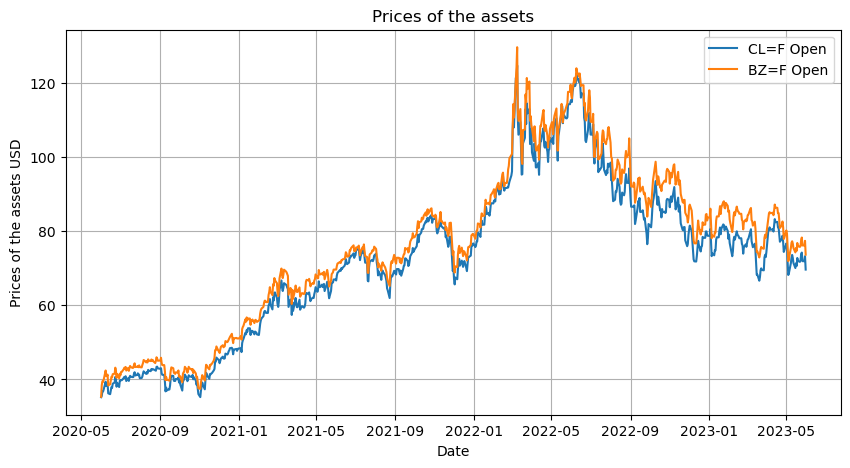

In [3]:
from basic_finance_tools import get_or_download_data, plot_df

# Specify the date range for data download
start = '2020-06-01'
end = '2023-06-01'

prices_data = get_or_download_data(tickers, start_date = start, end_date = end)
prices_data = prices_data.resample('1B').ffill().ffill().fillna(0)
plot_df(prices_data, title= 'Prices of the assets', unit='USD')

In [4]:
from basic_finance_tools import moving_Zscore, compute_position, adjust_position_volatility_targetting, compute_PNL, compute_metrics, plot_ds_hue

def show_strat_pairtrading(prices: pd.DataFrame, wz1: int, wz2:int =0, wvt: int =0) -> None:
    """
    Demonstrates a trading strategy based on moving Z-scores and visualizes the results.

    Parameters:
    - prices (pd.DataFrame): DataFrame containing asset prices.
    - wz1 (int): Window size for short-term Z-score calculation.
    - wz2 (int): Window size for long-term Z-score calculation.
    - wvt (int): Window size for volatility targeting adjustment.
    """
    tickers = prices.columns

    # Create a signal based on the difference of the prices zscore if wz1 != 0, by the difference of the prices if wz1=0
    signal = pd.DataFrame(index=prices.index, columns=tickers)
    signal[tickers[0]] = - moving_Zscore(prices[tickers[0]], window_size_zs=wz1) - moving_Zscore(prices[tickers[1]], window_size_zs=wz1)
    signal[tickers[1]] = - signal[tickers[0]]

    # If wz2 is specified, take the moving Z-Score of the computed signal as final signal
    if wz2: signal = moving_Zscore(signal, wz2)

    # Compute positions: if the signal is above a threshold, use it to scale the price; otherwise, position is 0
    positions = compute_position(signal, prices, threshold=0)

    # If a window size for volatility targeting (wvt) is provided, adjust positions to target constant volatility
    if wvt: positions = adjust_position_volatility_targetting(positions, window_size_vt=wvt)

    # Compute PnL: daily profit or loss based on the price changes and previous day's positions
    pnl = compute_PNL(positions, prices)

    # Compute and display key performance metrics (Sharpe ratio, turnover, basis points, etc.)
    metrics = compute_metrics(pnl, positions)
    print(metrics)

    # Plot daily PnL against the average absolute signal strength
    plot_ds_hue(pnl['DAILY'], signal.abs().mean(axis=1), title="PNL vs Signal Hue")

{'sharpe_ratio': 0.22, 'turnover': 32.1, 'bips': 2.6, 'effective_sharpe_ratio': 0.23, 'eff_bips': 2.84, 'eff_turnover': 32.03}


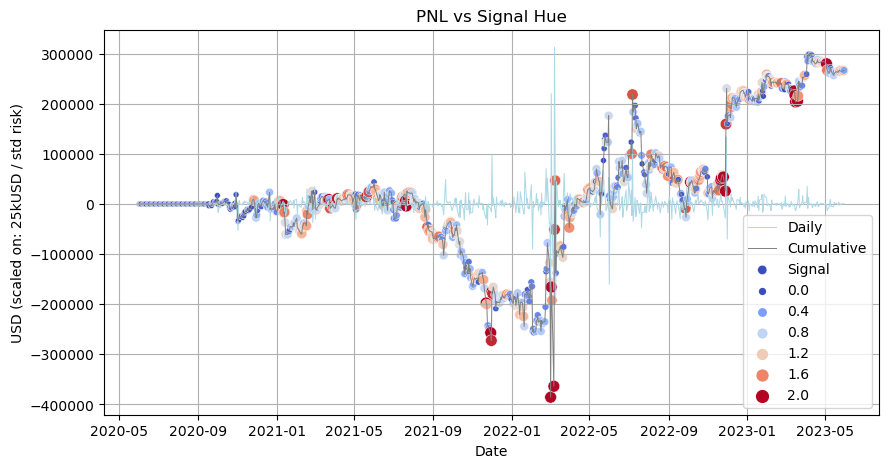

{'sharpe_ratio': 0.36, 'turnover': 26.6, 'bips': 4.7, 'effective_sharpe_ratio': 0.37, 'eff_bips': 5.05, 'eff_turnover': 25.93}


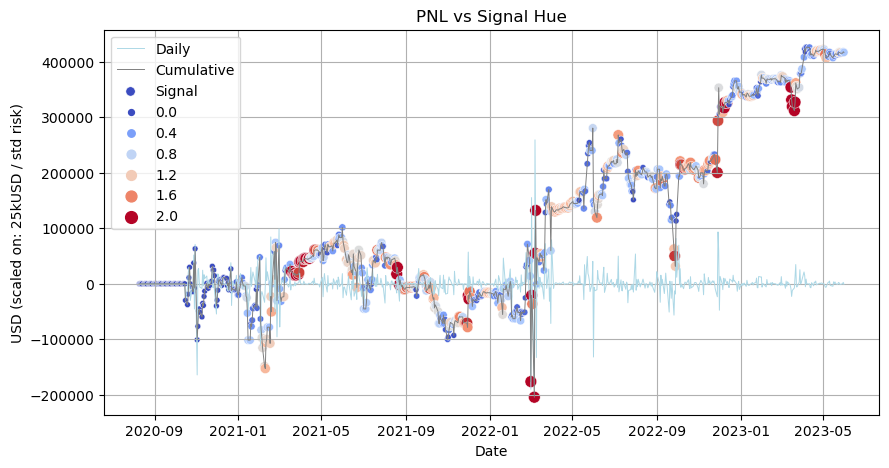

{'sharpe_ratio': 0.27, 'turnover': 35.6, 'bips': 3.2, 'effective_sharpe_ratio': 0.29, 'eff_bips': 3.64, 'eff_turnover': 34.5}


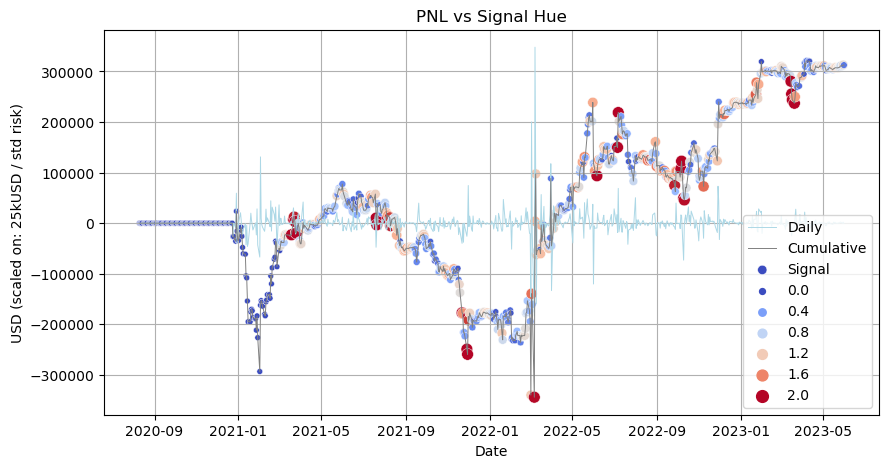

In [5]:
prices = prices_data.copy()
show_strat_pairtrading(prices,wz1=30)
show_strat_pairtrading(prices,wz1=50,wvt=50)
show_strat_pairtrading(prices,wz1=50, wz2=50, wvt=50)

# 3 different trajectory of the PnL using 2 different parameters set

wz1 [10, 12, 14, 16, 18, 21, 23, 25, 27, 30]
wz2 [10, 12, 14, 16, 18, 21, 23, 25, 27, 30]
wvt [0, 10, 12, 15, 17, 20, 22, 25, 27, 30]
Best Parameters: {'wz1': 16, 'wz2': 25, 'wvt': 15}
Best Result: 0.5


{'sharpe_ratio': 0.5, 'turnover': 51.2, 'bips': 3.2, 'effective_sharpe_ratio': 0.52, 'eff_bips': 3.49, 'eff_turnover': 50.73}


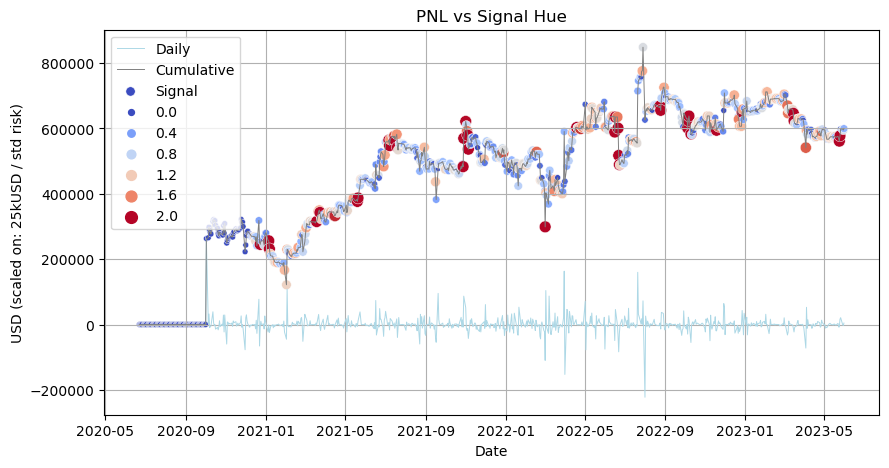

In [6]:
# Grid search optimization for wz1, wz2, wvt parameters for zscore strat
from basic_finance_tools import grid_search

def evaluate_PairTrading_strat(wz1: int, wz2:int, wvt: int,) -> float:
    # Strategy evaluation using Z-Score
    global prices

    tickers = prices.columns 
    signal = pd.DataFrame(index=prices.index, columns=tickers)
    signal[tickers[0]] = - moving_Zscore(prices[tickers[0]], window_size_zs=wz1) - moving_Zscore(prices[tickers[1]], window_size_zs=wz1)
    signal[tickers[1]] = - signal[tickers[0]]

    if wz2: signal = moving_Zscore(signal, wz2)

    positions = compute_position(signal, prices)
    if wvt: positions = adjust_position_volatility_targetting(positions, window_size_vt=wvt)

    pnl = compute_PNL(positions, prices)
    return np.abs(compute_metrics(pnl, positions)['sharpe_ratio'])

# Define parameter ranges for grid search
param_zscore = {
    'wz1': np.linspace(10, 30, 10, dtype=int).tolist(),
    'wz2': np.linspace(10, 30, 10, dtype=int).tolist(),
    'wvt': [0] + np.linspace(10, 30, 9, dtype=int).tolist()
}

# Print parameter ranges for verification
for key, value in param_zscore.items(): print(key, value)

# Perform grid search and print best parameters and result
best_params, best_result = grid_search(evaluate_PairTrading_strat, param_zscore)
print("Best Parameters:", best_params)
print("Best Result:", best_result)
print("\n")

# Visualize strategy using the best parameters
show_strat_pairtrading(prices, **best_params)

# With gridsearch, it hard to determine if we have been lucky and have picked a 
# good trajectory among N, which would be similar to overfitting, or if we have 
# correctly calibrate the parameters of the model